# Analyse des clusters obtenus par la méthode de clustering spectral

In [67]:
!pip install demoji
!pip install wordcloud
!pip install spacy

In [4]:
# téléchargement des stopwords français proposé par spacy
!python3 -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 8.4 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


In [8]:
import pandas as pd
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# pour prendre en charge les emojis dans les tweets
import demoji

# module pour le chargement des bases de données
import json

# gestion des stop words et de la lemmatisation avec spacy
import spacy
nlp = spacy.load('fr_core_news_md')
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop

# pour l'affichage de nuages de mots
from wordcloud import WordCloud

## 1. Import des données obtenues et création de nouvelles variables

### 1.1 Création d'un dataframe contenant les tweets.

In [97]:
# l'option dtype permet d'éviter des problèmes d'encodage
df = pd.read_json("tweets.json", dtype = False)
df.head(10)

author_id                created_at edit_history_tweet_ids  \
0            523849904 2022-12-13 21:14:43+00:00  [1602774039013240833]   
1  1546342369385226242 2022-12-13 21:14:33+00:00  [1602773998110216192]   
2  1600649374022995968 2022-12-13 21:14:32+00:00  [1602773991353090050]   
3            491271694 2022-12-13 21:14:27+00:00  [1602773973141446656]   
4  1088810623465590784 2022-12-13 21:14:27+00:00  [1602773970817785856]   
5           1379055842 2022-12-13 21:14:24+00:00  [1602773960424407041]   
6   962673658119557121 2022-12-13 21:14:20+00:00  [1602773943848505345]   
7  1570515228768587776 2022-12-13 21:14:19+00:00  [1602773937985040384]   
8            629486394 2022-12-13 21:14:15+00:00  [1602773922746978306]   
9           1536397663 2022-12-13 21:14:14+00:00  [1602773915113328644]   

                    id                                               text  
0  1602774039013240833  Mon mari est en dépression parce qu’on ne verr...  
1  1602773998110216192                                BIEN MESSI. #ARGCRO  
2  1602773991353090050  Les @ qui disent que Messi était invisible con...  
3  1602773973141446656             Messi c’est vraiment un joueur #ARGCRO  
4  1602773970817785856                              Messi magic 🪄 #ARGCRO  
5  1602773960424407041                                     Motm ? #ARGCRO  
6  1602773943848505345  Bof trop c'est trop, Kiki, tu es en mission ⚔️...  
7  1602773937985040384  Boateng peut enfin être soulagé, un héritier a...  
8  1602773922746978306  #FIFAWorldCup L'Argentine, premier pays qualif...  
9  1602773915113328644  Avec un Messi des grands jours victoire amplem...

### 1.2 Création d'une variable contenant le numéro de cluster de chaque utilisateur dans ce dataframe créé.

On crée d'abord un dictionnaire dont les clés sont les ids des utilisateurs et les valeurs sont les numéros de cluster.

À partir de ce dictionnaire, on peut créer la liste correspondant au numéro de cluster de chaque utilisateur, dans l'ordre donné par le dataframe.

Cette liste va ensuite permettre de créer une nouvelle colonne dans le dataframe, correspondant au cluster de chaque tweet (ie de l'auteur de ce tweet).

In [98]:
# On récupère les labels de cluster
labels = np.loadtxt("labels_spectral.txt")

# On récupère le dictionnaire des utilisateurs afin de récupérer
# les ids des utilisateurs
with open('dictionnaire_following-v2.json', 'r') as fp:
    dictionnaire = json.load(fp)

# les ids des utilisateurs
keys = dictionnaire.keys()

# pour l'instant, un dictionnaire où chaque clé renvoie à None
clusters = dictionnaire.fromkeys(keys)

# pour chaque utilisateur, le numéro de cluster qui lui correspond
for i,key in enumerate(list(keys)) :
    clusters[key] = int(labels[i])

# num_cluster va être la liste correspondant au numéro de cluster
# de chaque utilisateur dans l'ordre donné par le dataframe
num_cluster = []
for id_user in df['author_id']:
    num_cluster.append(clusters.get(str(id_user)))
    
df['id_cluster'] = num_cluster

## 2. Préparation des tweets en vue d'une analyse NLP

Avant de pouvoir analyser le vocabulaire utilisé dans les tweets de chaque cluster, il est nécessaire de les modifier.

Tout d'abord, nous allons donc supprimer les stopwords, qui ne sont pas utiles dans l'analyse.

Nous allons ensuite nettoyer les tweets, c'est-à-dire supprimer la ponctuation, les majuscules, les caractères spéciaux, les emojis, etc.

Enfin, nous allons lemmatiser les mots restants afin d'éviter de faire apparaître des mots de sens proches plusieurs fois.

### 2.1 Prise en charge des stopwords

In [111]:
# rajouter les mots qui apparaissent très souvent et qui ne sont pas utiles pour l'analyse
# on doit rajouter certains mots, car la lemmatisation (cf ci-desous) bug avec ces mots
stop_words_context = ["fifaworldcup", "argcro", "argentinavscroatia","l","qu","n","ca","nl","po","ar"]

stop_words = list(fr_stop)

for stop_word in stop_words_context :
    stop_words.append(stop_word)

### 2.2 Nettoyage du texte

In [100]:
def clean(text):
    '''
    Renvoie le texte nettoyé, après application de diverses transformations
    ---------
    Entrée : text : str : Le texte à étudier
    ---------
    Sortie : str : le texte nettoyé
    
    '''
    # tout mettre en minuscules
    res = text.lower()
    
    # suppression des chiffres (pour une analyse de vocabulaire, ils ne sont pas nécessaires)
    res = ''.join([i for i in res if not i.isdigit()])
    
    # suppression des emojis
    for item in demoji.findall(res):
        res = res.replace(item,"")
        
    # suppression des mentions
    res = re.sub("@[a-z0-9_]+","", res)
    
    # suppression des hashtags
    res = re.sub("#[a-z0-9_]+","", res)
    
    #suppression des liens 
    res = re.sub("\S*https:\S*", "", res)
    res = re.sub("\S*http:\S*", "", res)
        
    # suppression de la ponctuation
    res = res.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    
    # suppression des signes qui n'ont pas été enlevés auparavant
    res = re.sub("[’“…𓃵”«»—€°♂♀]"," ",res)
    
    #suppression des caractères seules
    res = re.sub("\s\S\s"," ",res)
    
    # transformation des caractères d'espacement (hors espace) en un seul espace à chaque fois
    res = re.sub("[\t\n\r\f\v]"," ",res)
    
    # raccourcissement de plusieurs espaces en un seul
    res = re.sub("[ ]{2,}"," ",res)
    
    return (res)

### 2.3 Lemmatisation du texte

In [112]:
def text_lemmatize(text):
    '''
    Renvoie le texte lemmatisé, ie dans lequel les mots du texte
    sont remplacés par un lemme, soit une forme canonique représentative
    de tous les mots ayant un sens proche
    Grâce à cette lemmatisation, on peut aussi s'occuper des stopwords
    ---------
    Entrée : text : str : Le texte à étudier, qui n'a pas besoin d'être
    nettoyé (on appliquera cette fonction sur un texte déjà nettoyé)
    ---------
    Sortie : str : le texte lemmatisé (sans les stopwords)
    
    '''
    # création d'un objet spacy
    nlp_text = nlp(text)
    
    # on crée un dictionnaire où à chaque mot, on lui fait
    # correspondre son lemme (de type str)
    dict_lemm = {token : token.lemma_ for token in nlp_text}
    
    # on crée la liste des mots lemmatisés
    words = []
    for x in nlp_text : 
        if len(x) >= 0 :
            lemme = dict_lemm[x]
            # on vérifie que le lemme n'est pas dans les stopwords
            if not lemme in stop_words :
                words.append(dict_lemm[x])
    
    # on renvoie le texte recréé à partir de tous ses mots lemmatisés
    # auquel on a enlevé les stopwords
    return ' '.join(words)

  mari dépression verr bien messi messi invisible con messi vraiment joueur messi magic motm bof trop trop kiki mission boateng pouvoir soulager héritier argentine pays qualif messi grand jour victoire amplem supporter argentin aller cas récital messi croate pa démérité léo messi fois nla chance viv masterclas septuple ballon argent assiste   renaissance    messi depui voir beaucoup retourner arge


### 2.4 Modification du dataframe

Dans le dataframe des tweets, on crée une nouvelle colonne "clean_text" qui contient le texte des tweets modifiés grâce à la fonction clean, ainsi qu'une colonne "tweet_lemma" qui contient le texte lemmatisé (et nettoyé).

In [113]:
df["clean_text"] = df["text"].apply(lambda x: clean(x))
df["tweet_lemma"] = df["clean_text"].apply(lambda x: text_lemmatize(x))
df.head()

author_id                created_at edit_history_tweet_ids  \
0            523849904 2022-12-13 21:14:43+00:00  [1602774039013240833]   
1  1546342369385226242 2022-12-13 21:14:33+00:00  [1602773998110216192]   
2  1600649374022995968 2022-12-13 21:14:32+00:00  [1602773991353090050]   
3            491271694 2022-12-13 21:14:27+00:00  [1602773973141446656]   
4  1088810623465590784 2022-12-13 21:14:27+00:00  [1602773970817785856]   

                    id                                               text  \
0  1602774039013240833  Mon mari est en dépression parce qu’on ne verr...   
1  1602773998110216192                                BIEN MESSI. #ARGCRO   
2  1602773991353090050  Les @ qui disent que Messi était invisible con...   
3  1602773973141446656             Messi c’est vraiment un joueur #ARGCRO   
4  1602773970817785856                              Messi magic 🪄 #ARGCRO   

   id_cluster                                         clean_text  \
0         0.0  mon mari est en dépression parce qu on ne verr...   
1         1.0                                        bien messi    
2         0.0  les qui disent que messi était invisible contr...   
3         1.0                      messi est vraiment un joueur    
4         0.0                                       messi magic    

                                         tweet_lemma  
0              mari dépression voir miss croatie cas  
1                                         bien messi  
2  messi invisible contre croatie devoir ajuster ...  
3                              messi vraiment joueur  
4                                        messi magic

## 3. Affichage de la fréquence des mots sous la forme de graphiques

### 3.1 Tri des mots par nombre d'occurences décroissant dans l'ensemble des tweets

In [116]:
def tri_occurence (text) :
    '''
    Renvoie un tableau des mots de text triés par 
    ordre décroissant de leur fréquence
    ainsi que les fréquences correspondantes
    ---------
    Entrée : text : str : Le texte à modifier
    ---------
    Sortie : 
        mots_tries_frequence : numpy array (1) : le tableau des mots triés par fréquence
        frequences : numpy array (1) : les fréquences correspondantes
    
    '''
    # le tableau numpy contenant tous les mots
    tableau_mots = np.array(text.split())
    
    # les éléments (uniques) ainsi que leur dans l'ensemble des mots
    elements, frequences = np.unique(tableau_mots, return_counts=True)

    # on trie par valeur décroissante de fréquence
    indices_tri_frequences = np.argsort(frequences)[::-1]

    # les éléments dans l'ordre décroissant de leur fréquence
    mots_tries_frequence = elements[indices_tri_frequences]

    return (mots_tries_frequence,frequences[indices_tri_frequences])

In [124]:
# malheureusement, on est obligé de retransformer le texte à chaque fois car les fonctions
# to_string() permettant de transformer une colonne de dataframe en str ne renvoie pas un
# résultat permettant d'étudier la fréquence des mots (numéros de ligne, ponctuation impromptues,...)
ensemble_tweets = text_lemmatize(clean(df["text"].to_string()))
tweets_tries_frequence,frequences = tri_occurence (ensemble_tweets)
print(tweets_tries_frequence,frequences)

['messi' 'argentine' 'croatie' ... 'huma' 'hum' 'lune'] [1935  640  635 ...    1    1    1]


### 3.2 Affichage des mots les plus fréquents sous la forme d'un histogramme

In [118]:
def affichage_histogramme(text,title) :
    '''
    Affiche l'histogramme des 10 mots les plus fréquents
    ---------
    Entrée : 
        text : str : le texte à étudier
        title : str : le titre du graphique
    ---------
    Sortie : None (Affiche l'histogramme)
    '''
    tweets_tries_frequence,frequence = tri_occurence (text)
    plt.style.use('dark_background')
    plt.figure(figsize=(15, 9))
    sns.barplot(x = tweets_tries_frequence[:10], y = frequences[:10]).set_title(title)

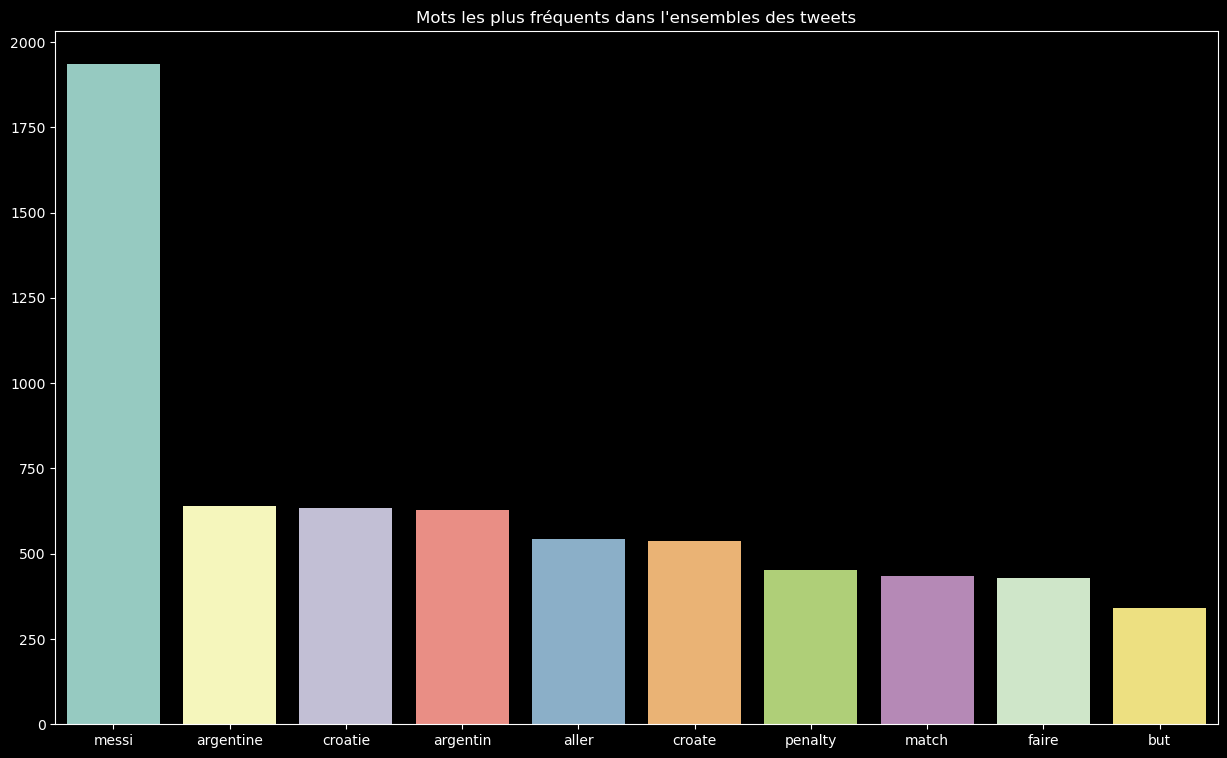

In [119]:
affichage_histogramme(ensemble_tweets,"Mots les plus fréquents dans l'ensembles des tweets")

### 3.4 Affichage des mots les plus fréquents sous la forme d'un histogramme pour chacun des clusters

In [125]:
def histogramme_cluster(cluster) :
    '''
    Affiche l'histogramme des 10 mots les plus fréquents
    pour le cluster considéré
    ---------
    Entrée : cluster : int : le numéro du cluster
    ---------
    Sortie : None (Affiche l'histogramme)
    '''
    
    # le dataframe correspondant au cluster considéré
    df_cloud = df[df['id_cluster'] == cluster]
    
    # l'ensembles des tweets à l'intérieur de chaque cluster
    ensemble_tweets_cluster = text_lemmatize(clean(df_cloud["text"].to_string()))
    
    affichage_histogramme(ensemble_tweets_cluster,"Mots les plus fréquents pour les tweets du cluster n°" + str(int(cluster)))

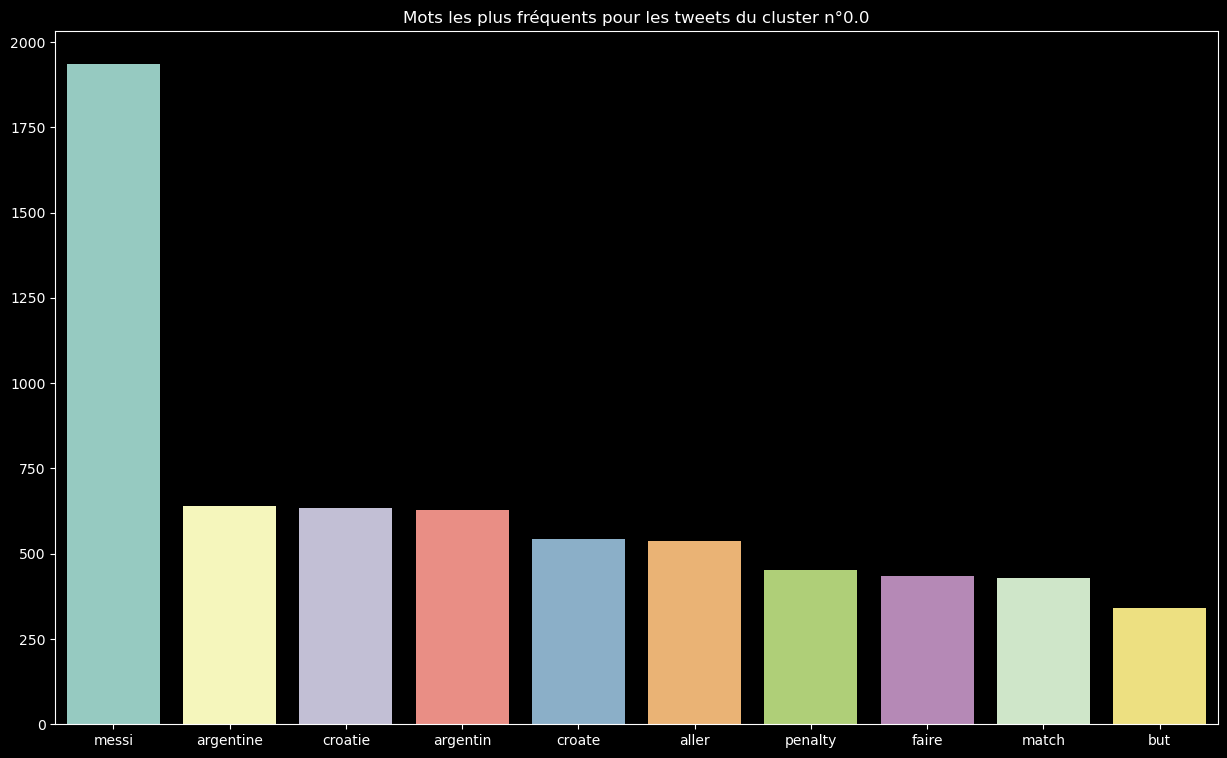

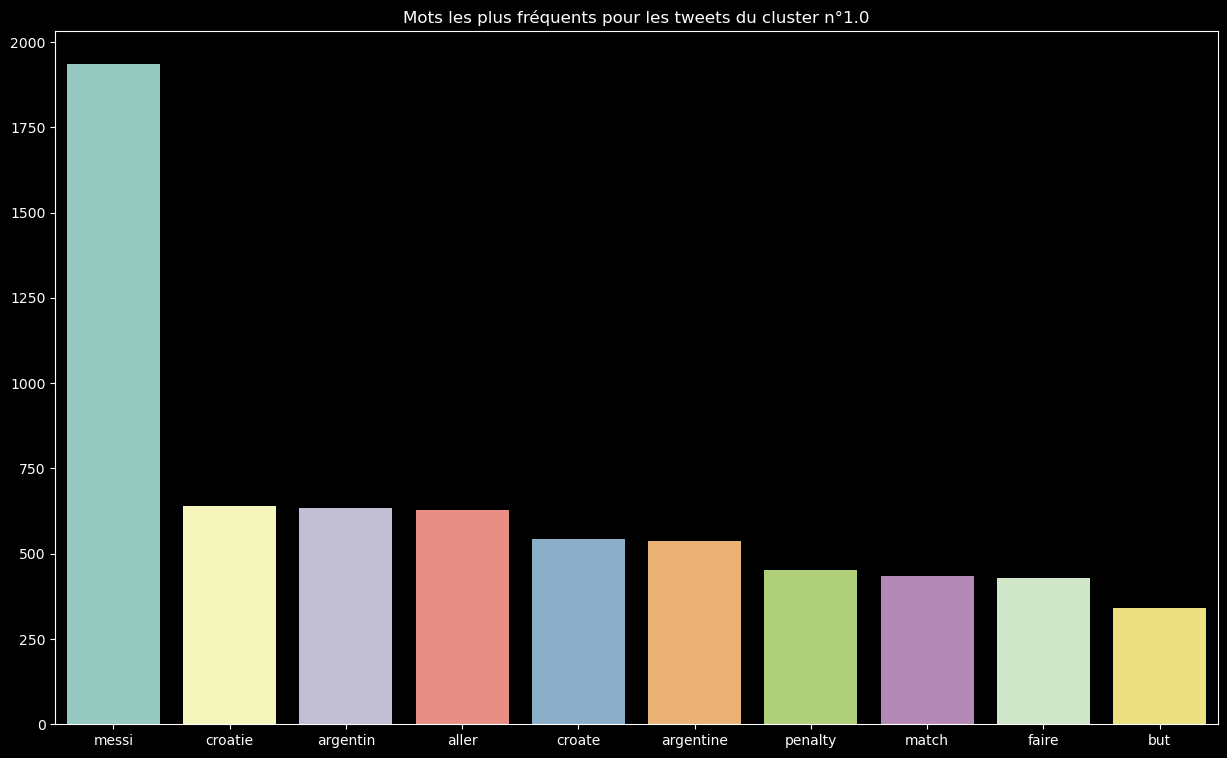

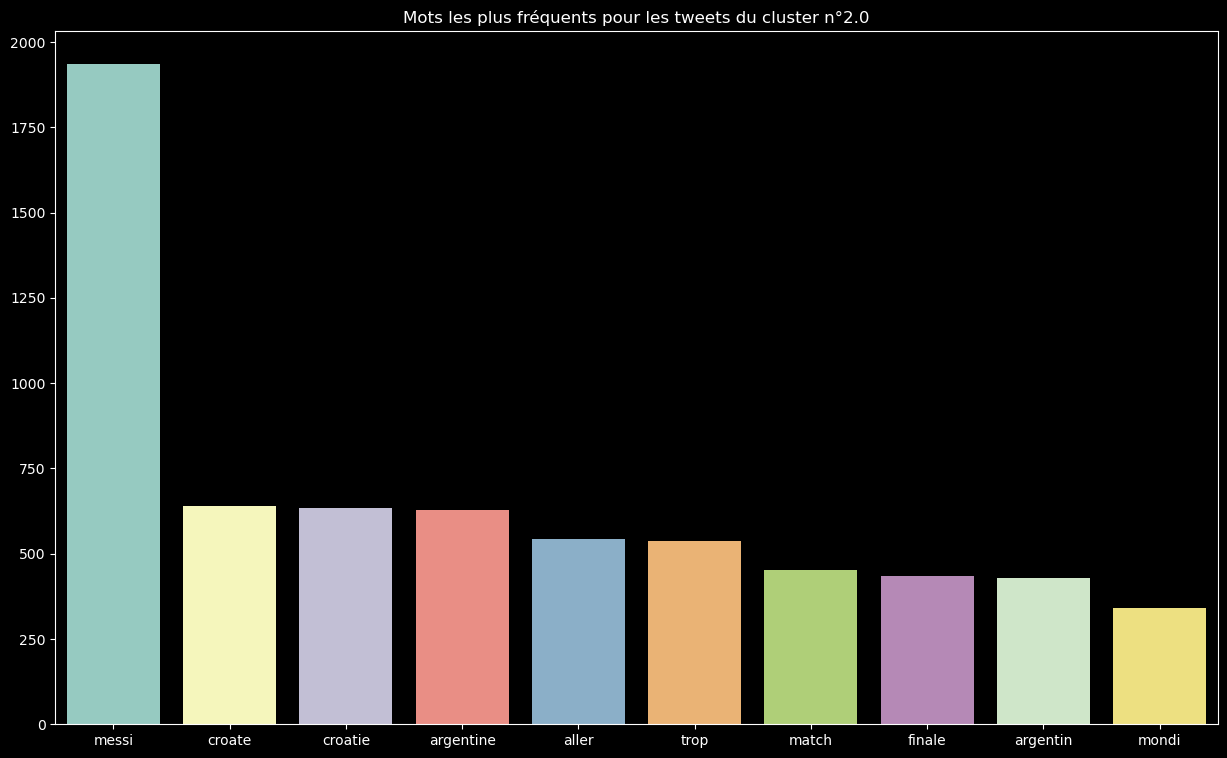

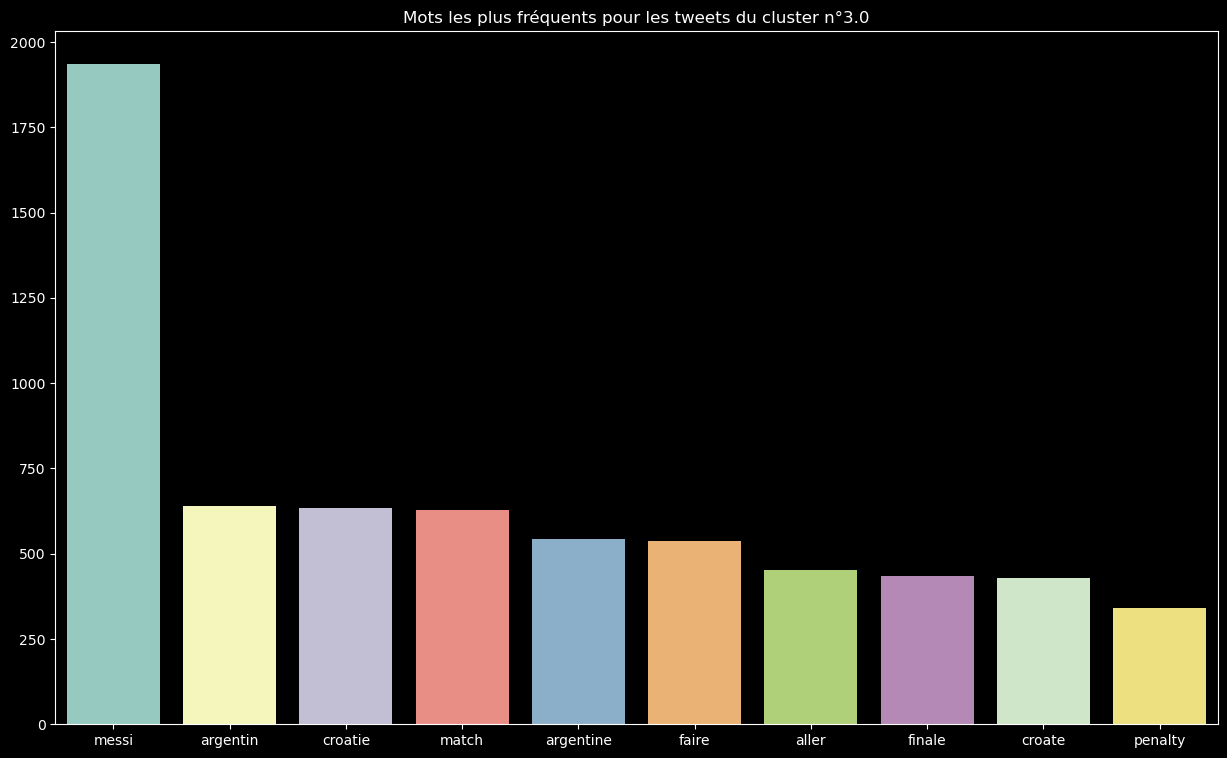

In [123]:
liste_clusters = np.unique(labels)
for cluster in liste_clusters:
    histogramme_cluster(cluster)

## 4. Création des wordclouds

### 4.1 Wordcloud de l'integralité des tweets

In [127]:
def affichage_wordcloud (text) :
    '''
    Affiche le wordcloud du texte rentré en argument
    ---------
    Entrée : text : str : le texte à étudier
    ---------
    Sortie : None (Affiche le worcloud)
    '''
    wordcloud = WordCloud(stopwords=stop_words, width=800, height=500,
                          random_state=21, max_font_size=110, min_word_length=4).generate(text)
    plt.figure(figsize=(19, 12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

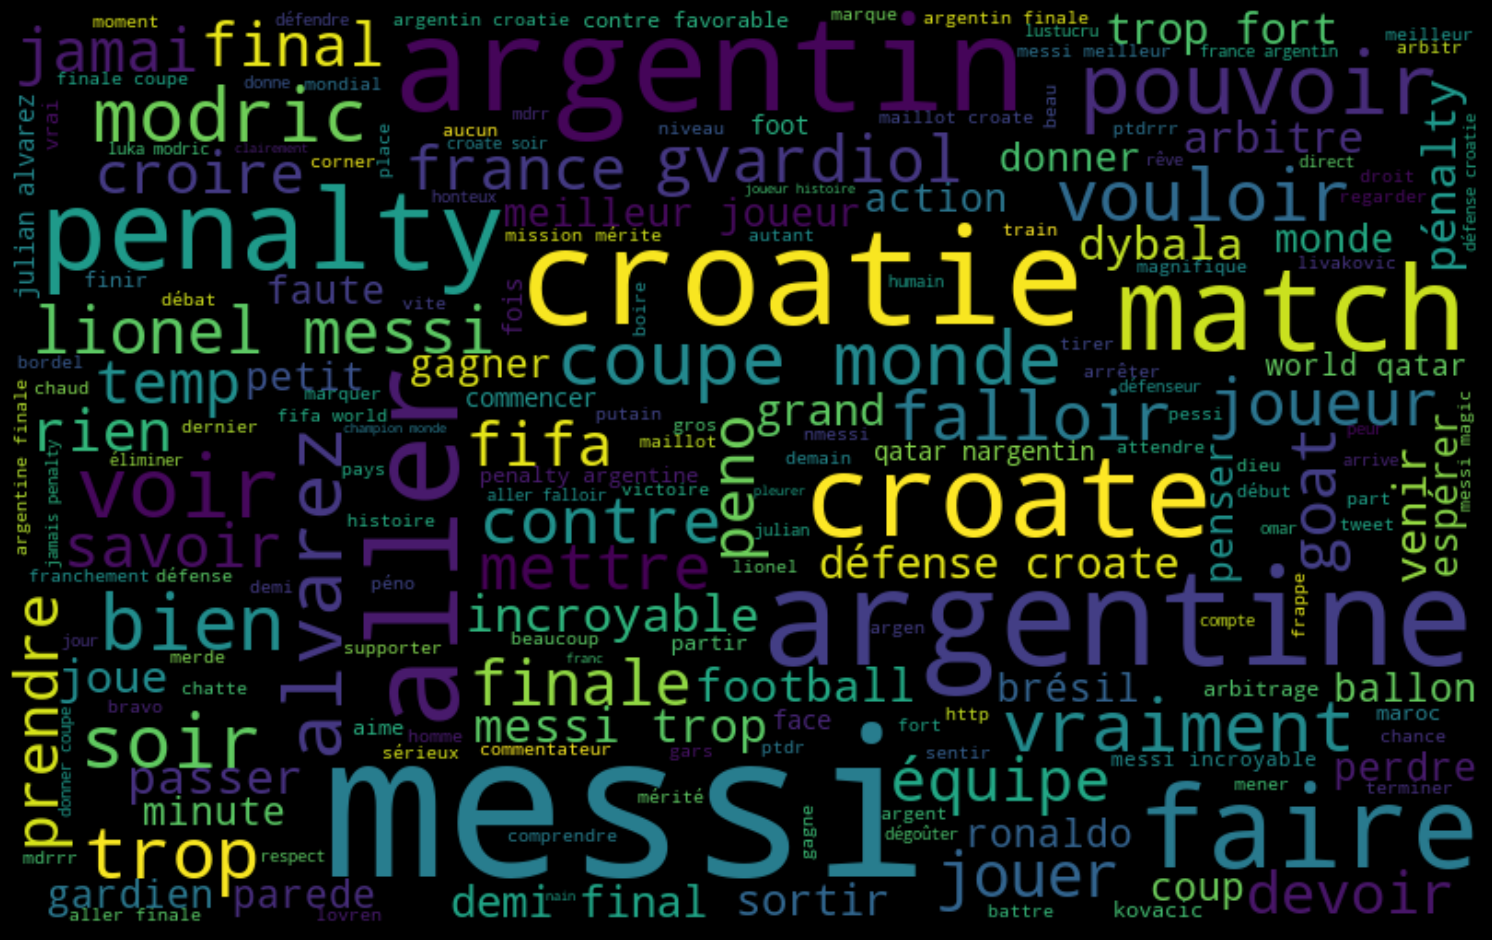

In [128]:
affichage_wordcloud(ensemble_tweets)

### 4.2 Wordcloud par cluster

In [129]:
def wordcloud_cluster(cluster) :
    '''
    Affiche le wordcloud du cluster rentré en argument
    ---------
    Entrée : cluster : int : le numéro du cluster
    ---------
    Sortie : None (Affiche le worcloud)
    '''
    
    # le dataframe correspondant au cluster considéré
    df_cloud = df[df['id_cluster'] == cluster]
    
    # l'ensembles des tweets à l'intérieur de chaque cluster
    ensemble_tweets_cluster = text_lemmatize(clean(df_cloud["text"].to_string()))
    
    affichage_wordcloud (ensemble_tweets_cluster)

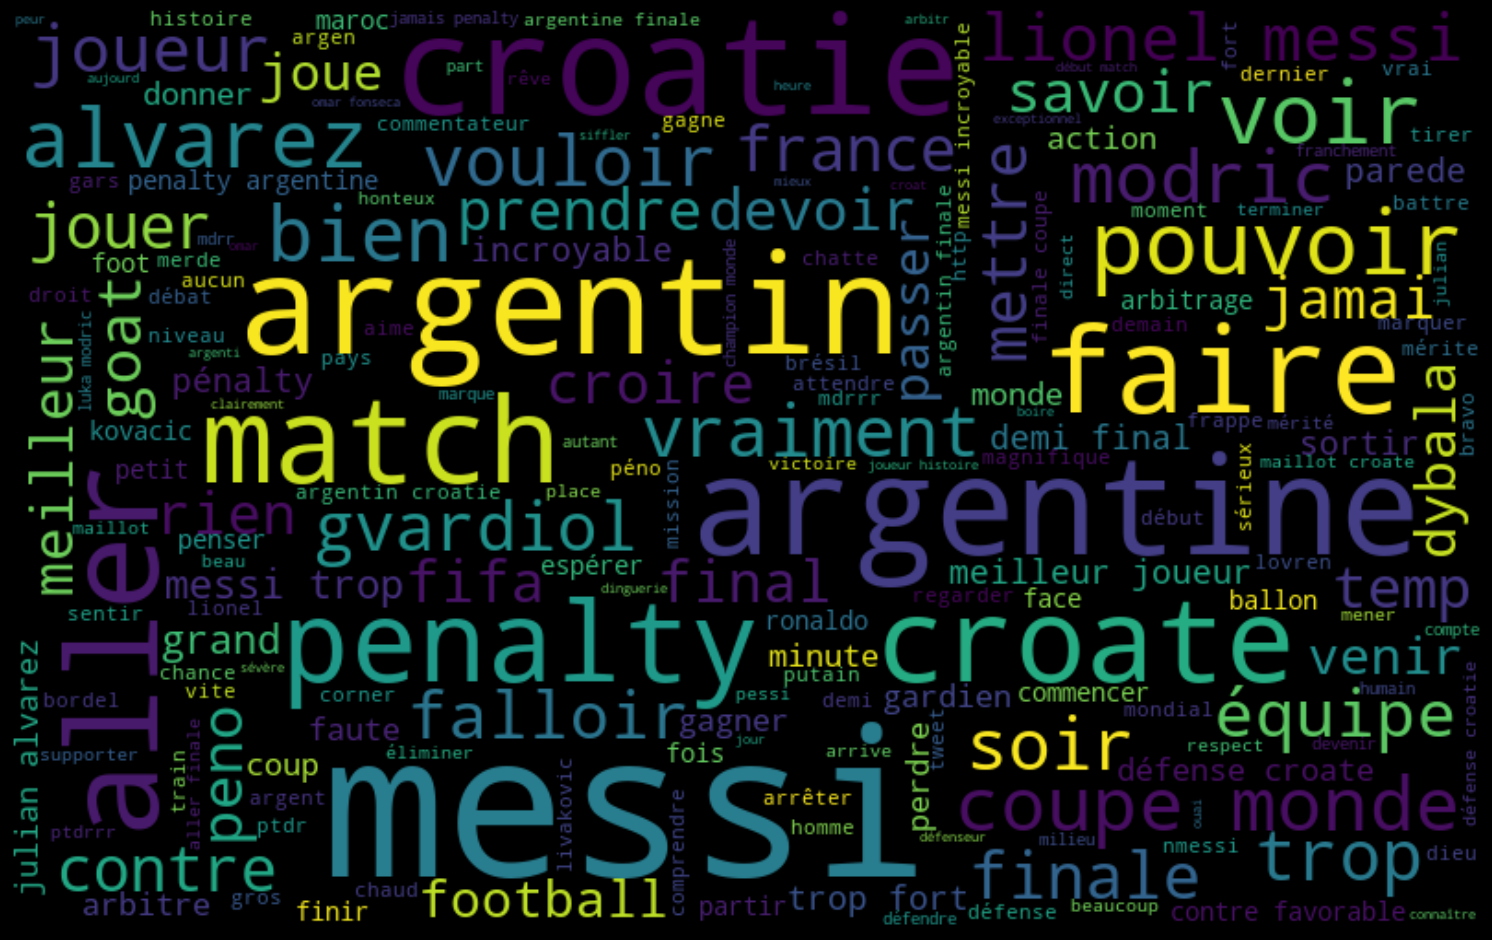

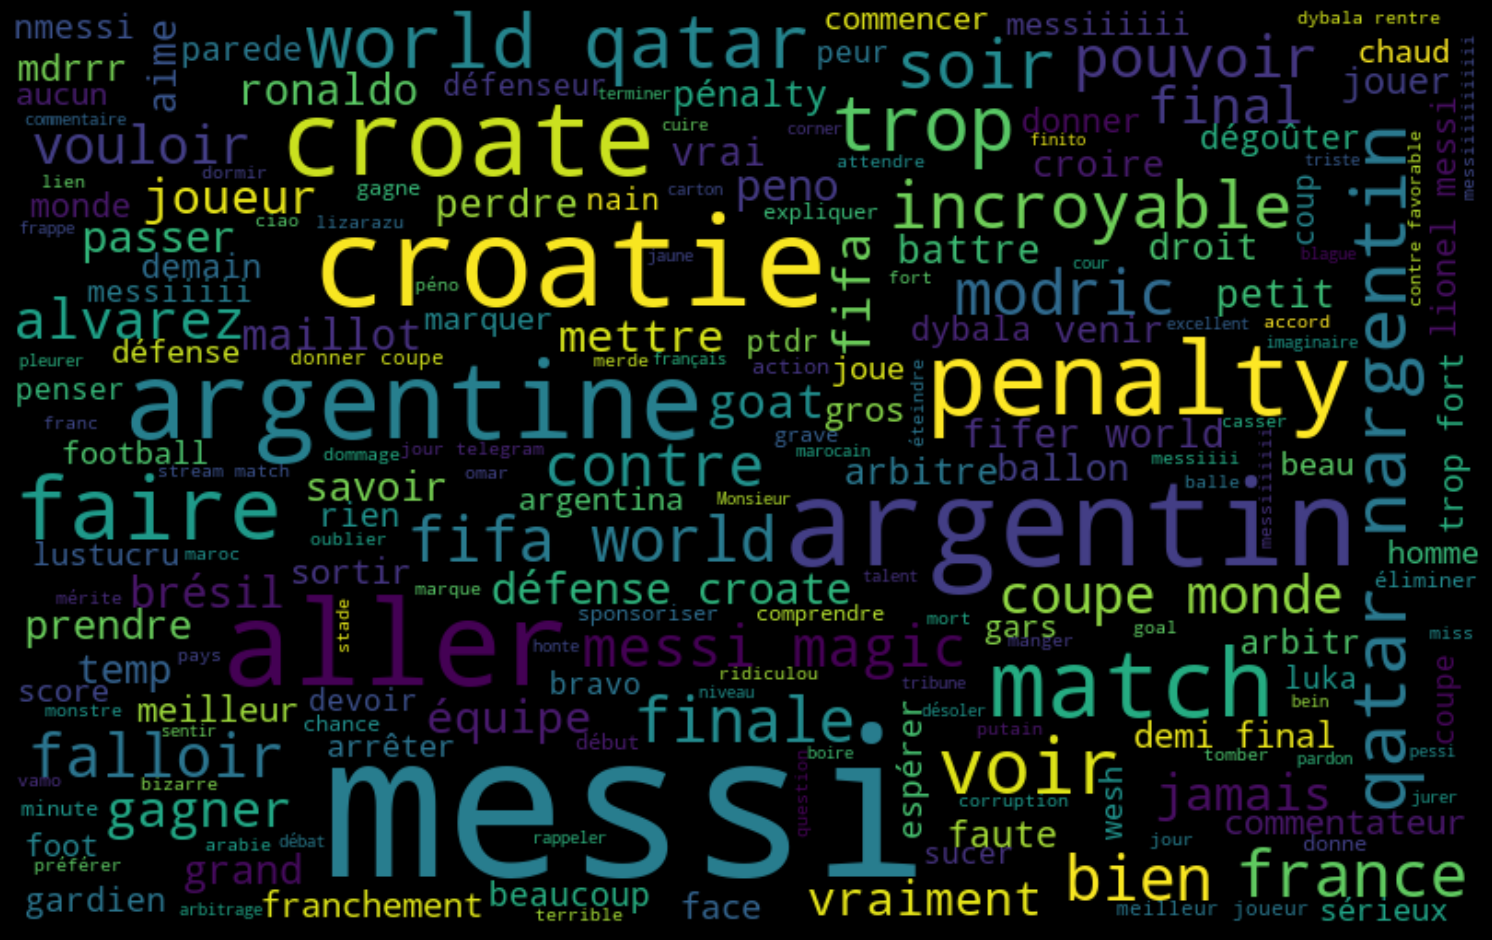

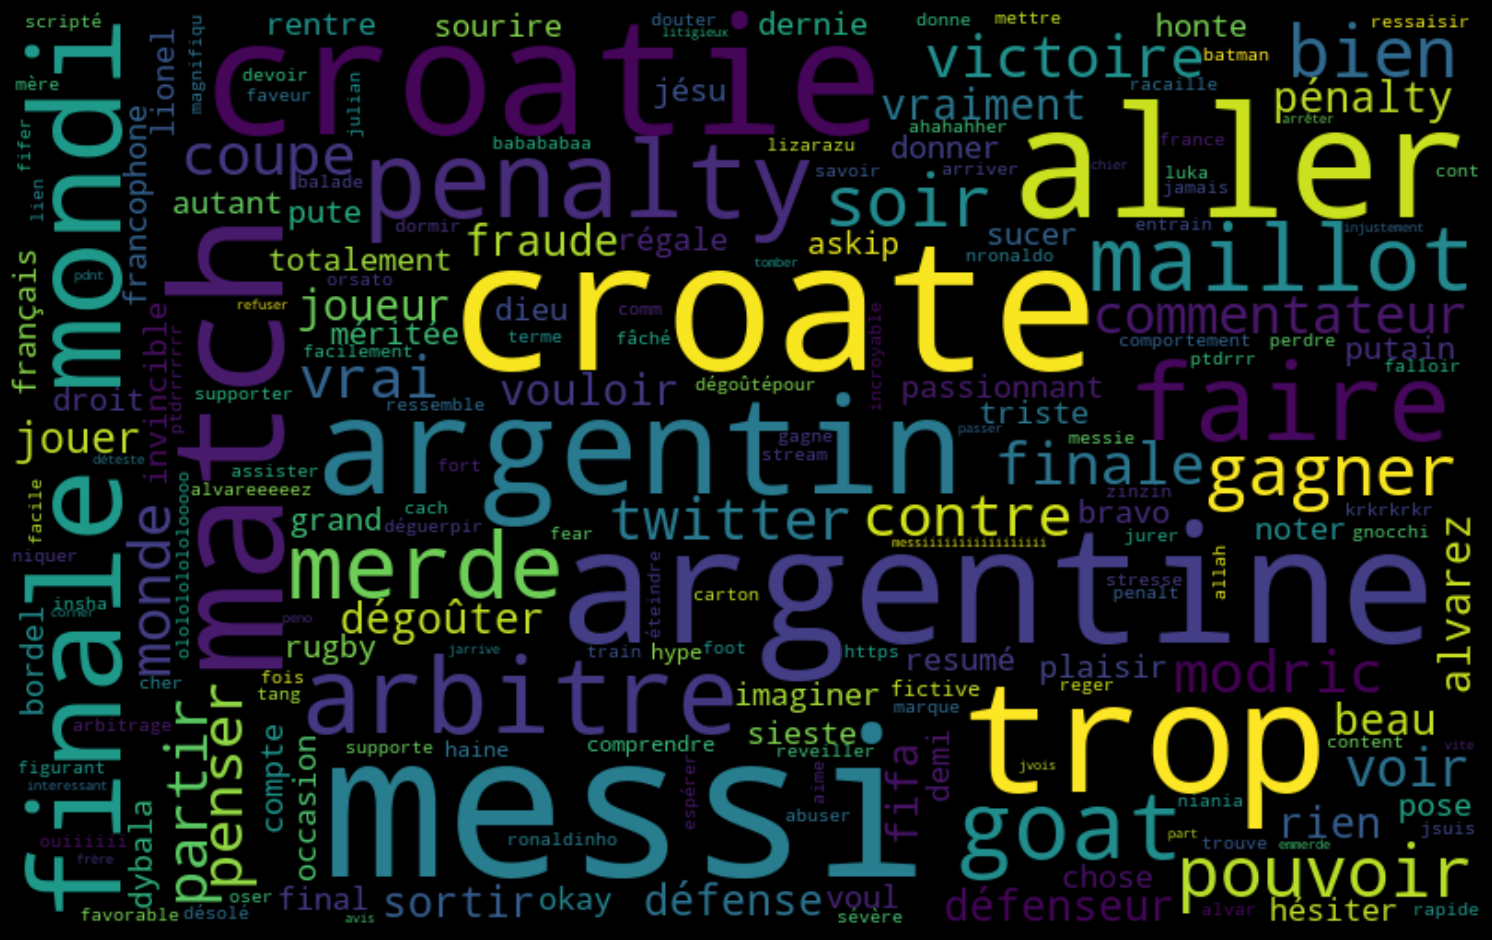

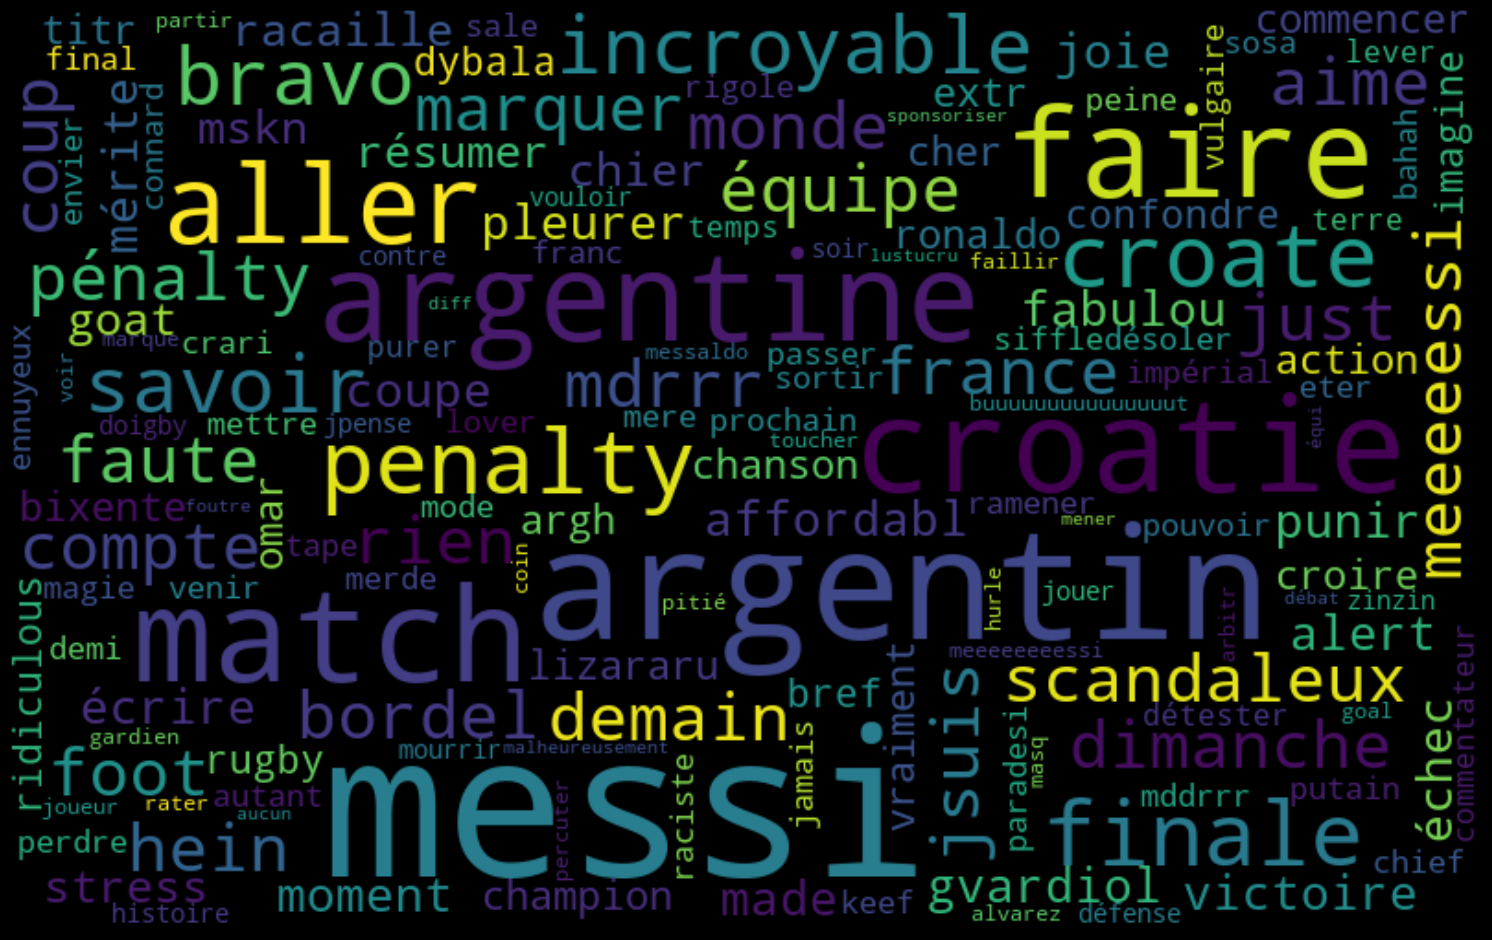

In [130]:
for cluster in liste_clusters:
    wordcloud_cluster(cluster)

## 5. Analyse des caractéristiques autres que le vocabulaire

Au sein des tweets, on va maintenant analyser d'autres caractéristiques que le vocabulaire.

Pour notre analyse, il peut être utile de connaître le nombre de hashtags dans chaque tweet, le nombre de majuscules ainsi que le nombre de points d'exclamation.

Le dataframe initial contient déjà le nombre de likes et de retweets.

In [131]:
def count_hashtags(text):
    '''
    Renvoie le nombre de hashtags dans un tweet
    -------------
    Entrée : text : str : Le texte à étudier
    -------------
    Sortie : int : Le nombre de hashtags
    '''
    # les hashtags dans un tweet sont placés avant un mot
    find = re.compile("([#]\w+)").findall(text)
    return len(find)


def count_exclamation(text):
    '''
    Renvoie le nombre de point d'exclamation dans un tweet
    -------------
    Entrée : text : str : Le texte à étudier
    -------------
    Sortie : int : Le nombre de hashtags
    '''
    # les points d'exclamation dans un texte sont placés après un mot / caractère
    find = re.compile("(\w?\s?[!])").findall(text)
    return len(find)


def count_maj(text):
    '''
    Renvoie le nombre de majuscules dans un tweet
    -------------
    Entrée : text : str : Le texte à étudier
    -------------
    Sortie : int : Le nombre de majuscules
    '''
    find = re.compile("([A-Z][A-Z]+)").findall(text)
    return len(find)



df["nb_hashtags"] = df["text"].apply(lambda x : count_hashtags(x))
df["nb_exclamation"] = df["text"].apply(lambda x : count_exclamation(x))
df["nb_maj"] = df["text"].apply(lambda x : count_maj(x))

Statistiques descriptives sur les variables, par cluster.

In [18]:
round(df.describe(), 3)

author_id            id  nb_hashtags  nb_exclamation    nb_maj
count  9.054000e+03  9.054000e+03     9054.000        9054.000  9054.000
mean   6.905736e+17  1.602758e+18        1.547           0.305     1.997
std    6.471105e+17  8.875457e+12        1.193           1.043     2.296
min    6.530300e+04  1.602736e+18        1.000           0.000     0.000
25%    1.050174e+09  1.602750e+18        1.000           0.000     1.000
50%    8.415568e+17  1.602760e+18        1.000           0.000     1.000
75%    1.306720e+18  1.602764e+18        2.000           0.000     2.000
max    1.602762e+18  1.602774e+18       18.000          22.000    38.000

Il faut ajouter une variable "cluster" dans le dataframe, qui contient l'identifiant du cluster auquel appartient chaque utilisateur.